In [1]:
import random
import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 5

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 10000

# percentage of words that will be used for validation
percentage_split = 0.60

# number of epochs for fitting the model training step
nb_epochs = 200

In [3]:
# total number of combinations
nb_letters**nb_chars

11881376

In [4]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars), dtype=int)
    
    for w in range(nb_words):
        optim_tentative = False
        if optim_tentative == True and w%10 != 0:
            i = random.randint(0, nb_letters-1)
            for c in range(nb_chars):
                words[w, c] = ord('a') + i
        else:
            for c in range(nb_chars):
                i = random.randint(0, nb_letters-1)
                words[w, c] = ord('a') + i
                
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

In [5]:
nb_features = nb_chars

# This returns a tensor
inputs = layers.Input(shape=(nb_chars,), dtype='float32', name='main_input')

# a layer instance is callable on a tensor, and returns a tensor
x = layers.Dense(4096, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(2048, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(64, activation='relu', name='hl_2')(x)

outputs = []
losses = {}
for o in range(nb_chars):
    name_i = 'output_'+str(o)
    output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
    outputs.append(output_i)
    losses[name_i] = 'categorical_crossentropy'

coding_model = keras.models.Model(inputs=inputs, outputs=outputs)

coding_model.compile(optimizer='rmsprop',
                     loss=losses,
                     metrics=['accuracy'])       

In [6]:
print(coding_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 5)            0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4096)         24576       main_input[0][0]                 
__________________________________________________________________________________________________
output_0 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_1 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_2 (

In [7]:
def print_readable_inputs(x):
    words = []
    for w in x:
        word = ''
        for c in w:
            word += chr(c)
        words.append(word)
   
    print(words)

In [8]:
def print_readable_outputs_(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    
    c_i = 0
    for char in outputs:

        s_i = 0
        for sample in char:

            l_i = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_probs in sample:
                if letter_probs > best_value:
                    best_value = letter_probs
                    best_letter = l_i
                l_i += 1
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [9]:
def print_readable_outputs(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    c_i = 0
    for char in outputs:
        s_i = 0
        for sample in char:
            best_letter = np.argmax(sample)
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [10]:
x = create_inputs(nb_words, nb_chars, nb_letters)
print('x: (as readable inputs)')

first_n_samples = 4

print_readable_inputs(x[:first_n_samples])
print('x (partial):\n', x[:first_n_samples], 'out of ',len(x))
print()

# process the x data as useful ANN input data
scaler = StandardScaler()
x_train  = scaler.fit_transform(x)

print('x_train:\n', x_train[:first_n_samples], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y (readable):\n', y)
print()

# process the y data as useful ANN output data
y_train0 = keras.utils.to_categorical(y, nb_letters)
print('y (less readable):\n', y_train0[:first_n_samples], 'out of ',len(y_train0))
print('')

# process the y data as useful ANN multiple-outputs data
y_train = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_train = y_train0[:,c,:]
    y_train.append(yi_train)

# Not really displayable, henced commented
#print('y_train):')
#print(y_train[:first_n_samples])

x: (as readable inputs)
['kfzlc', 'piusm', 'tsbil', 'hiixq']
x (partial):
 [[107 102 122 108  99]
 [112 105 117 115 109]
 [116 115  98 105 108]
 [104 105 105 120 113]] out of  10000

x_train:
 [[-0.32792525 -0.99875678  1.65344344 -0.20652286 -1.397286  ]
 [ 0.33959348 -0.60076114  0.98416862  0.72960357 -0.0735971 ]
 [ 0.87360846  0.72589097 -1.55907569 -0.6077199  -0.20596599]
 [-0.72843648 -0.60076114 -0.62209094  1.3982653   0.45587846]] out of  10000

y (readable):
 [[10  5 25 11  2]
 [15  8 20 18 12]
 [19 18  1  8 11]
 ...
 [16 15  7 17  9]
 [12  4 10 11 14]
 [ 4 23 16  9 17]]

y (less readable):
 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
history = coding_model.fit(x_train, y_train, validation_split=percentage_split, batch_size=32, epochs=nb_epochs, verbose=1)

Train on 4000 samples, validate on 6000 samples
Epoch 1/200
4000/4000 [==============================] - 1s 341us/step - loss: 13.1881 - output_0_loss: 2.6374 - output_1_loss: 2.6306 - output_2_loss: 2.6425 - output_3_loss: 2.6458 - output_4_loss: 2.6317 - output_0_acc: 0.1438 - output_1_acc: 0.1390 - output_2_acc: 0.1408 - output_3_acc: 0.1397 - output_4_acc: 0.1490 - val_loss: 11.7739 - val_output_0_loss: 2.3508 - val_output_1_loss: 2.3466 - val_output_2_loss: 2.3722 - val_output_3_loss: 2.3417 - val_output_4_loss: 2.3627 - val_output_0_acc: 0.1880 - val_output_1_acc: 0.1722 - val_output_2_acc: 0.1737 - val_output_3_acc: 0.1868 - val_output_4_acc: 0.1720
Epoch 2/200
4000/4000 [==============================] - 1s 216us/step - loss: 11.0172 - output_0_loss: 2.2014 - output_1_loss: 2.2061 - output_2_loss: 2.2083 - output_3_loss: 2.2110 - output_4_loss: 2.1903 - output_0_acc: 0.2245 - output_1_acc: 0.2102 - output_2_acc: 0.2142 - output_3_acc: 0.2093 - output_4_acc: 0.2198 - val_loss: 1

4000/4000 [==============================] - 1s 162us/step - loss: 6.5364 - output_0_loss: 1.3047 - output_1_loss: 1.3204 - output_2_loss: 1.3039 - output_3_loss: 1.3134 - output_4_loss: 1.2940 - output_0_acc: 0.4768 - output_1_acc: 0.4850 - output_2_acc: 0.4778 - output_3_acc: 0.4793 - output_4_acc: 0.4847 - val_loss: 6.9679 - val_output_0_loss: 1.4419 - val_output_1_loss: 1.4042 - val_output_2_loss: 1.4371 - val_output_3_loss: 1.3242 - val_output_4_loss: 1.3606 - val_output_0_acc: 0.4267 - val_output_1_acc: 0.4197 - val_output_2_acc: 0.4210 - val_output_3_acc: 0.4737 - val_output_4_acc: 0.4422
Epoch 15/200
4000/4000 [==============================] - 1s 175us/step - loss: 6.3527 - output_0_loss: 1.2722 - output_1_loss: 1.2857 - output_2_loss: 1.2730 - output_3_loss: 1.2668 - output_4_loss: 1.2550 - output_0_acc: 0.4903 - output_1_acc: 0.4840 - output_2_acc: 0.4873 - output_3_acc: 0.4982 - output_4_acc: 0.5010 - val_loss: 6.8221 - val_output_0_loss: 1.4683 - val_output_1_loss: 1.3773 

4000/4000 [==============================] - 1s 161us/step - loss: 4.7407 - output_0_loss: 0.9441 - output_1_loss: 0.9657 - output_2_loss: 0.9423 - output_3_loss: 0.9438 - output_4_loss: 0.9449 - output_0_acc: 0.6275 - output_1_acc: 0.6145 - output_2_acc: 0.6280 - output_3_acc: 0.6342 - output_4_acc: 0.6268 - val_loss: 5.2696 - val_output_0_loss: 1.0702 - val_output_1_loss: 1.0289 - val_output_2_loss: 1.0706 - val_output_3_loss: 1.0243 - val_output_4_loss: 1.0755 - val_output_0_acc: 0.5688 - val_output_1_acc: 0.6003 - val_output_2_acc: 0.5542 - val_output_3_acc: 0.5728 - val_output_4_acc: 0.5623
Epoch 28/200
4000/4000 [==============================] - 1s 164us/step - loss: 4.6139 - output_0_loss: 0.9198 - output_1_loss: 0.9439 - output_2_loss: 0.9147 - output_3_loss: 0.9218 - output_4_loss: 0.9138 - output_0_acc: 0.6370 - output_1_acc: 0.6255 - output_2_acc: 0.6390 - output_3_acc: 0.6445 - output_4_acc: 0.6470 - val_loss: 5.2352 - val_output_0_loss: 1.0568 - val_output_1_loss: 1.0556 

4000/4000 [==============================] - 1s 172us/step - loss: 3.6365 - output_0_loss: 0.7315 - output_1_loss: 0.7389 - output_2_loss: 0.7259 - output_3_loss: 0.7233 - output_4_loss: 0.7169 - output_0_acc: 0.7255 - output_1_acc: 0.7250 - output_2_acc: 0.7318 - output_3_acc: 0.7340 - output_4_acc: 0.7240 - val_loss: 4.1628 - val_output_0_loss: 0.8495 - val_output_1_loss: 0.8375 - val_output_2_loss: 0.8739 - val_output_3_loss: 0.7739 - val_output_4_loss: 0.8280 - val_output_0_acc: 0.6637 - val_output_1_acc: 0.6478 - val_output_2_acc: 0.6525 - val_output_3_acc: 0.7075 - val_output_4_acc: 0.6832
Epoch 41/200
4000/4000 [==============================] - 1s 171us/step - loss: 3.5764 - output_0_loss: 0.7106 - output_1_loss: 0.7292 - output_2_loss: 0.7108 - output_3_loss: 0.7160 - output_4_loss: 0.7098 - output_0_acc: 0.7385 - output_1_acc: 0.7268 - output_2_acc: 0.7390 - output_3_acc: 0.7358 - output_4_acc: 0.7380 - val_loss: 4.1831 - val_output_0_loss: 0.8230 - val_output_1_loss: 0.8489 

4000/4000 [==============================] - 1s 171us/step - loss: 2.8794 - output_0_loss: 0.5713 - output_1_loss: 0.5976 - output_2_loss: 0.5721 - output_3_loss: 0.5580 - output_4_loss: 0.5804 - output_0_acc: 0.8045 - output_1_acc: 0.7945 - output_2_acc: 0.7993 - output_3_acc: 0.8083 - output_4_acc: 0.7963 - val_loss: 3.7743 - val_output_0_loss: 0.7403 - val_output_1_loss: 0.7756 - val_output_2_loss: 0.7173 - val_output_3_loss: 0.8652 - val_output_4_loss: 0.6759 - val_output_0_acc: 0.7015 - val_output_1_acc: 0.6987 - val_output_2_acc: 0.7113 - val_output_3_acc: 0.6153 - val_output_4_acc: 0.7508
Epoch 54/200
4000/4000 [==============================] - 1s 180us/step - loss: 2.8393 - output_0_loss: 0.5631 - output_1_loss: 0.5842 - output_2_loss: 0.5628 - output_3_loss: 0.5737 - output_4_loss: 0.5556 - output_0_acc: 0.8060 - output_1_acc: 0.7977 - output_2_acc: 0.8053 - output_3_acc: 0.7940 - output_4_acc: 0.8150 - val_loss: 3.5624 - val_output_0_loss: 0.7406 - val_output_1_loss: 0.7351 

4000/4000 [==============================] - 1s 170us/step - loss: 2.3146 - output_0_loss: 0.4676 - output_1_loss: 0.4771 - output_2_loss: 0.4642 - output_3_loss: 0.4501 - output_4_loss: 0.4556 - output_0_acc: 0.8445 - output_1_acc: 0.8520 - output_2_acc: 0.8518 - output_3_acc: 0.8548 - output_4_acc: 0.8580 - val_loss: 3.0680 - val_output_0_loss: 0.5719 - val_output_1_loss: 0.6248 - val_output_2_loss: 0.5807 - val_output_3_loss: 0.6486 - val_output_4_loss: 0.6420 - val_output_0_acc: 0.8033 - val_output_1_acc: 0.7587 - val_output_2_acc: 0.7825 - val_output_3_acc: 0.7515 - val_output_4_acc: 0.7432
Epoch 67/200
4000/4000 [==============================] - 1s 166us/step - loss: 2.2732 - output_0_loss: 0.4541 - output_1_loss: 0.4718 - output_2_loss: 0.4576 - output_3_loss: 0.4483 - output_4_loss: 0.4415 - output_0_acc: 0.8568 - output_1_acc: 0.8505 - output_2_acc: 0.8570 - output_3_acc: 0.8565 - output_4_acc: 0.8640 - val_loss: 3.0119 - val_output_0_loss: 0.5786 - val_output_1_loss: 0.5735 

4000/4000 [==============================] - 1s 170us/step - loss: 1.8583 - output_0_loss: 0.3690 - output_1_loss: 0.3853 - output_2_loss: 0.3688 - output_3_loss: 0.3627 - output_4_loss: 0.3724 - output_0_acc: 0.8967 - output_1_acc: 0.8817 - output_2_acc: 0.8955 - output_3_acc: 0.8967 - output_4_acc: 0.8905 - val_loss: 2.5213 - val_output_0_loss: 0.4910 - val_output_1_loss: 0.5645 - val_output_2_loss: 0.4940 - val_output_3_loss: 0.4712 - val_output_4_loss: 0.5006 - val_output_0_acc: 0.8350 - val_output_1_acc: 0.7875 - val_output_2_acc: 0.8138 - val_output_3_acc: 0.8377 - val_output_4_acc: 0.8263
Epoch 80/200
4000/4000 [==============================] - 1s 162us/step - loss: 1.8265 - output_0_loss: 0.3589 - output_1_loss: 0.3860 - output_2_loss: 0.3610 - output_3_loss: 0.3557 - output_4_loss: 0.3648 - output_0_acc: 0.8942 - output_1_acc: 0.8860 - output_2_acc: 0.9000 - output_3_acc: 0.8922 - output_4_acc: 0.8892 - val_loss: 2.6847 - val_output_0_loss: 0.5893 - val_output_1_loss: 0.4975 

4000/4000 [==============================] - 1s 166us/step - loss: 1.4949 - output_0_loss: 0.3000 - output_1_loss: 0.3158 - output_2_loss: 0.2897 - output_3_loss: 0.2929 - output_4_loss: 0.2966 - output_0_acc: 0.9167 - output_1_acc: 0.9077 - output_2_acc: 0.9290 - output_3_acc: 0.9207 - output_4_acc: 0.9213 - val_loss: 2.2638 - val_output_0_loss: 0.4462 - val_output_1_loss: 0.5101 - val_output_2_loss: 0.4049 - val_output_3_loss: 0.4022 - val_output_4_loss: 0.5004 - val_output_0_acc: 0.8425 - val_output_1_acc: 0.8052 - val_output_2_acc: 0.8767 - val_output_3_acc: 0.8697 - val_output_4_acc: 0.8088
Epoch 93/200
4000/4000 [==============================] - 1s 162us/step - loss: 1.4725 - output_0_loss: 0.2885 - output_1_loss: 0.3073 - output_2_loss: 0.2900 - output_3_loss: 0.2876 - output_4_loss: 0.2991 - output_0_acc: 0.9253 - output_1_acc: 0.9185 - output_2_acc: 0.9263 - output_3_acc: 0.9248 - output_4_acc: 0.9128 - val_loss: 2.0967 - val_output_0_loss: 0.4599 - val_output_1_loss: 0.4813 

4000/4000 [==============================] - 1s 193us/step - loss: 1.1944 - output_0_loss: 0.2326 - output_1_loss: 0.2575 - output_2_loss: 0.2304 - output_3_loss: 0.2322 - output_4_loss: 0.2417 - output_0_acc: 0.9455 - output_1_acc: 0.9353 - output_2_acc: 0.9450 - output_3_acc: 0.9412 - output_4_acc: 0.9353 - val_loss: 1.8544 - val_output_0_loss: 0.3818 - val_output_1_loss: 0.3756 - val_output_2_loss: 0.3802 - val_output_3_loss: 0.2853 - val_output_4_loss: 0.4316 - val_output_0_acc: 0.8682 - val_output_1_acc: 0.8780 - val_output_2_acc: 0.8632 - val_output_3_acc: 0.9387 - val_output_4_acc: 0.8405
Epoch 106/200
4000/4000 [==============================] - 1s 193us/step - loss: 1.1781 - output_0_loss: 0.2306 - output_1_loss: 0.2499 - output_2_loss: 0.2320 - output_3_loss: 0.2227 - output_4_loss: 0.2429 - output_0_acc: 0.9417 - output_1_acc: 0.9340 - output_2_acc: 0.9483 - output_3_acc: 0.9490 - output_4_acc: 0.9375 - val_loss: 1.7630 - val_output_0_loss: 0.3356 - val_output_1_loss: 0.3810

4000/4000 [==============================] - 1s 164us/step - loss: 0.9646 - output_0_loss: 0.1869 - output_1_loss: 0.2093 - output_2_loss: 0.1894 - output_3_loss: 0.1830 - output_4_loss: 0.1960 - output_0_acc: 0.9575 - output_1_acc: 0.9470 - output_2_acc: 0.9585 - output_3_acc: 0.9610 - output_4_acc: 0.9513 - val_loss: 1.6489 - val_output_0_loss: 0.3491 - val_output_1_loss: 0.3532 - val_output_2_loss: 0.2828 - val_output_3_loss: 0.3048 - val_output_4_loss: 0.3589 - val_output_0_acc: 0.8855 - val_output_1_acc: 0.8863 - val_output_2_acc: 0.9202 - val_output_3_acc: 0.9012 - val_output_4_acc: 0.8690
Epoch 119/200
4000/4000 [==============================] - 1s 173us/step - loss: 0.9536 - output_0_loss: 0.1853 - output_1_loss: 0.2075 - output_2_loss: 0.1847 - output_3_loss: 0.1813 - output_4_loss: 0.1948 - output_0_acc: 0.9577 - output_1_acc: 0.9472 - output_2_acc: 0.9615 - output_3_acc: 0.9617 - output_4_acc: 0.9495 - val_loss: 1.6825 - val_output_0_loss: 0.3524 - val_output_1_loss: 0.3155

4000/4000 [==============================] - 1s 174us/step - loss: 0.7633 - output_0_loss: 0.1496 - output_1_loss: 0.1674 - output_2_loss: 0.1493 - output_3_loss: 0.1422 - output_4_loss: 0.1547 - output_0_acc: 0.9682 - output_1_acc: 0.9633 - output_2_acc: 0.9715 - output_3_acc: 0.9753 - output_4_acc: 0.9635 - val_loss: 1.4223 - val_output_0_loss: 0.2502 - val_output_1_loss: 0.3645 - val_output_2_loss: 0.2849 - val_output_3_loss: 0.2499 - val_output_4_loss: 0.2729 - val_output_0_acc: 0.9278 - val_output_1_acc: 0.8665 - val_output_2_acc: 0.9210 - val_output_3_acc: 0.9230 - val_output_4_acc: 0.9198
Epoch 132/200
4000/4000 [==============================] - 1s 185us/step - loss: 0.7509 - output_0_loss: 0.1474 - output_1_loss: 0.1598 - output_2_loss: 0.1413 - output_3_loss: 0.1465 - output_4_loss: 0.1559 - output_0_acc: 0.9680 - output_1_acc: 0.9607 - output_2_acc: 0.9720 - output_3_acc: 0.9700 - output_4_acc: 0.9627 - val_loss: 1.2604 - val_output_0_loss: 0.2210 - val_output_1_loss: 0.2938

4000/4000 [==============================] - 1s 180us/step - loss: 0.6101 - output_0_loss: 0.1159 - output_1_loss: 0.1393 - output_2_loss: 0.1110 - output_3_loss: 0.1160 - output_4_loss: 0.1278 - output_0_acc: 0.9770 - output_1_acc: 0.9700 - output_2_acc: 0.9828 - output_3_acc: 0.9772 - output_4_acc: 0.9698 - val_loss: 1.0931 - val_output_0_loss: 0.1861 - val_output_1_loss: 0.2859 - val_output_2_loss: 0.2076 - val_output_3_loss: 0.1860 - val_output_4_loss: 0.2274 - val_output_0_acc: 0.9545 - val_output_1_acc: 0.9072 - val_output_2_acc: 0.9435 - val_output_3_acc: 0.9542 - val_output_4_acc: 0.9367
Epoch 145/200
4000/4000 [==============================] - 1s 190us/step - loss: 0.5983 - output_0_loss: 0.1151 - output_1_loss: 0.1317 - output_2_loss: 0.1089 - output_3_loss: 0.1152 - output_4_loss: 0.1275 - output_0_acc: 0.9772 - output_1_acc: 0.9730 - output_2_acc: 0.9820 - output_3_acc: 0.9805 - output_4_acc: 0.9735 - val_loss: 1.2095 - val_output_0_loss: 0.2097 - val_output_1_loss: 0.2797

4000/4000 [==============================] - 1s 188us/step - loss: 0.4790 - output_0_loss: 0.0874 - output_1_loss: 0.1074 - output_2_loss: 0.0920 - output_3_loss: 0.0899 - output_4_loss: 0.1022 - output_0_acc: 0.9873 - output_1_acc: 0.9765 - output_2_acc: 0.9865 - output_3_acc: 0.9850 - output_4_acc: 0.9778 - val_loss: 1.1430 - val_output_0_loss: 0.2079 - val_output_1_loss: 0.2416 - val_output_2_loss: 0.2620 - val_output_3_loss: 0.1592 - val_output_4_loss: 0.2723 - val_output_0_acc: 0.9345 - val_output_1_acc: 0.9273 - val_output_2_acc: 0.9067 - val_output_3_acc: 0.9627 - val_output_4_acc: 0.9062
Epoch 158/200
4000/4000 [==============================] - 1s 194us/step - loss: 0.4776 - output_0_loss: 0.0877 - output_1_loss: 0.1097 - output_2_loss: 0.0887 - output_3_loss: 0.0903 - output_4_loss: 0.1011 - output_0_acc: 0.9835 - output_1_acc: 0.9745 - output_2_acc: 0.9848 - output_3_acc: 0.9860 - output_4_acc: 0.9765 - val_loss: 0.9951 - val_output_0_loss: 0.1755 - val_output_1_loss: 0.2090

4000/4000 [==============================] - 1s 197us/step - loss: 0.3831 - output_0_loss: 0.0704 - output_1_loss: 0.0909 - output_2_loss: 0.0684 - output_3_loss: 0.0737 - output_4_loss: 0.0797 - output_0_acc: 0.9873 - output_1_acc: 0.9795 - output_2_acc: 0.9900 - output_3_acc: 0.9888 - output_4_acc: 0.9852 - val_loss: 0.8597 - val_output_0_loss: 0.1716 - val_output_1_loss: 0.2196 - val_output_2_loss: 0.1509 - val_output_3_loss: 0.1467 - val_output_4_loss: 0.1708 - val_output_0_acc: 0.9555 - val_output_1_acc: 0.9277 - val_output_2_acc: 0.9548 - val_output_3_acc: 0.9652 - val_output_4_acc: 0.9468
Epoch 171/200
4000/4000 [==============================] - 1s 176us/step - loss: 0.3833 - output_0_loss: 0.0706 - output_1_loss: 0.0871 - output_2_loss: 0.0729 - output_3_loss: 0.0690 - output_4_loss: 0.0837 - output_0_acc: 0.9862 - output_1_acc: 0.9843 - output_2_acc: 0.9865 - output_3_acc: 0.9900 - output_4_acc: 0.9798 - val_loss: 0.8132 - val_output_0_loss: 0.1346 - val_output_1_loss: 0.2269

4000/4000 [==============================] - 1s 188us/step - loss: 0.3028 - output_0_loss: 0.0556 - output_1_loss: 0.0713 - output_2_loss: 0.0543 - output_3_loss: 0.0565 - output_4_loss: 0.0651 - output_0_acc: 0.9925 - output_1_acc: 0.9845 - output_2_acc: 0.9942 - output_3_acc: 0.9922 - output_4_acc: 0.9868 - val_loss: 0.7205 - val_output_0_loss: 0.1465 - val_output_1_loss: 0.2323 - val_output_2_loss: 0.1048 - val_output_3_loss: 0.1148 - val_output_4_loss: 0.1220 - val_output_0_acc: 0.9550 - val_output_1_acc: 0.9142 - val_output_2_acc: 0.9778 - val_output_3_acc: 0.9732 - val_output_4_acc: 0.9708
Epoch 184/200
4000/4000 [==============================] - 1s 189us/step - loss: 0.2986 - output_0_loss: 0.0550 - output_1_loss: 0.0687 - output_2_loss: 0.0574 - output_3_loss: 0.0542 - output_4_loss: 0.0633 - output_0_acc: 0.9928 - output_1_acc: 0.9875 - output_2_acc: 0.9900 - output_3_acc: 0.9925 - output_4_acc: 0.9888 - val_loss: 0.8299 - val_output_0_loss: 0.1670 - val_output_1_loss: 0.1669

4000/4000 [==============================] - 1s 170us/step - loss: 0.2370 - output_0_loss: 0.0415 - output_1_loss: 0.0590 - output_2_loss: 0.0426 - output_3_loss: 0.0455 - output_4_loss: 0.0485 - output_0_acc: 0.9933 - output_1_acc: 0.9870 - output_2_acc: 0.9945 - output_3_acc: 0.9942 - output_4_acc: 0.9925 - val_loss: 0.6560 - val_output_0_loss: 0.1080 - val_output_1_loss: 0.1326 - val_output_2_loss: 0.1175 - val_output_3_loss: 0.1313 - val_output_4_loss: 0.1665 - val_output_0_acc: 0.9735 - val_output_1_acc: 0.9612 - val_output_2_acc: 0.9715 - val_output_3_acc: 0.9627 - val_output_4_acc: 0.9392
Epoch 197/200
4000/4000 [==============================] - 1s 160us/step - loss: 0.2369 - output_0_loss: 0.0423 - output_1_loss: 0.0552 - output_2_loss: 0.0412 - output_3_loss: 0.0444 - output_4_loss: 0.0538 - output_0_acc: 0.9940 - output_1_acc: 0.9903 - output_2_acc: 0.9963 - output_3_acc: 0.9955 - output_4_acc: 0.9898 - val_loss: 0.5583 - val_output_0_loss: 0.0913 - val_output_1_loss: 0.1636

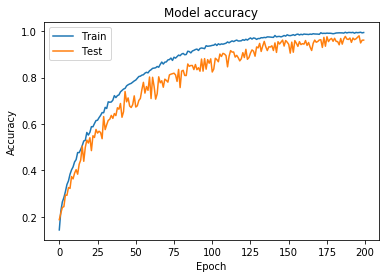

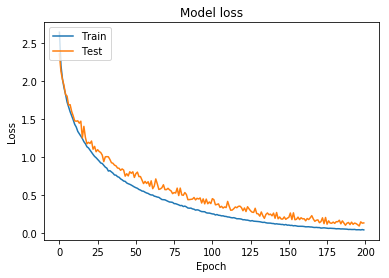

In [12]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['output_0_acc'])
plt.plot(history.history['val_output_0_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
nb_words_to_test = 100000

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
x_test_scaled  = scaler.transform(x_test)

y_test_raw = encrypt(x_test, nb_words_to_test, nb_chars)
y_test_raw_cate = keras.utils.to_categorical(y_test_raw, nb_letters)

# process the y data as useful ANN multiple-outputs data
y_test = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_test = y_test_raw_cate[:,c,:]
    y_test.append(yi_test)


print('\n# Evaluate on test data')
results = coding_model.evaluate(x_test_scaled, y_test, batch_size=128)
for r in range(len(results)):
    print(coding_model.metrics_names[r],':',results[r])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



# Evaluate on test data
100000/100000 [==============================] - 2s 20us/step
loss : 0.608820455379486
output_0_loss : 0.12797732916116714
output_1_loss : 0.12703988629817964
output_2_loss : 0.1091656908273697
output_3_loss : 0.08084671403884888
output_4_loss : 0.1637908337879181
output_0_acc : 0.96503
output_1_acc : 0.96431
output_2_acc : 0.97602
output_3_acc : 0.98366
output_4_acc : 0.94185


In [14]:
nb_words_to_test = 3

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
print_readable_inputs(x_test)
print("x_test=\n", x_test)

x_test_scaled  = scaler.transform(x_test)
print("x_test_scaled=\n", x_test_scaled)
print('-->')

prediction = coding_model.predict(x_test_scaled)
#print(prediction)
print('prediction')
print_readable_outputs(prediction, nb_words_to_test, nb_chars)

print('check prediction')
y_test = encrypt(x_test, nb_words_to_test, nb_chars)
print("y_test=\n", y_test)

['llhak', 'zupys', 'ymymg']
x_test=
 [[108 108 104  97 107]
 [122 117 112 121 115]
 [121 109 121 109 103]]
x_test_scaled=
 [[-0.1944215  -0.20276551 -0.75594591 -1.67757868 -0.33833488]
 [ 1.67463093  0.99122139  0.3148938   1.53199765  0.72061624]
 [ 1.54112718 -0.0701003   1.51958848 -0.07279052 -0.86781044]]
-->
prediction
['11 11 7 0 10', '25 20 15 24 18', '24 12 24 12 6']
check prediction
y_test=
 [[11 11  7  0 10]
 [25 20 15 24 18]
 [24 12 24 12  6]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
